## Ranking Neural Net

In [5]:
import torch 
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, MinMaxScaler
# import tensorboard
from torch.utils.tensorboard import SummaryWriter
from scipy.stats import pearsonr

In [6]:
class PrismDataset(Dataset):
    def __init__(self, response_df, feature_df, feature_importance_df, top_k_features, slate_length, quantile_transfomer=None, prioritize_sensitive=True):
        self.response_df = response_df
        self.feature_df = feature_df
        self.feature_importance_df = feature_importance_df
        self.top_k_features = top_k_features
        self.slate_length = slate_length
        self.prioritize_sensitive = prioritize_sensitive
        
        # Get the top k features based on importance
        self.top_features = self.feature_importance_df.nlargest(top_k_features, "importance")["feature"].tolist()

        # filter self.feature_df to include only the top features
        self.feature_df = self.feature_df.loc[:, self.top_features]

        # quantile transform all features
        if not quantile_transfomer:
            self.quantile_transfomer = PowerTransformer()
            self.quantile_transfomer.fit(self.feature_df)
        else:
            self.quantile_transfomer = quantile_transfomer

        # quantile transform feature_df
        self.feature_df = pd.DataFrame(self.quantile_transfomer.transform(self.feature_df), columns=self.feature_df.columns, index=self.feature_df.index)

        # quantile transform labels
        self.label_transformer = MinMaxScaler()
        self.response_df["LFC.cb"] = self.label_transformer.fit_transform(self.response_df[["LFC.cb"]])
        if self.prioritize_sensitive:
            self.response_df.loc[:, "LFC.cb"] = 1 - self.response_df.loc[:, "LFC.cb"]
        # scale from 0 to 5
        self.response_df.loc[:, "LFC.cb"] = self.response_df.loc[:, "LFC.cb"] * 5

        # Join response_df and feature_df on "ccle_name"
        self.joined_df = pd.merge(self.response_df, self.feature_df, on="ccle_name")
        # set index to "ccle_name"
        self.joined_df = self.joined_df.set_index("ccle_name")

        # Order the columns
        self.cols = self.top_features + ["LFC.cb"]
        self.joined_df = self.joined_df.loc[:, self.cols]

        # impute missing values
        self.joined_df = self.joined_df.fillna(-1)

        # get ccle_names
        self.ccle_names = self.joined_df.index.tolist()

        if len(self.ccle_names) < self.slate_length:
            self.slate_length = len(self.ccle_names)

    def __len__(self):
        return len(self.ccle_names)

    def __getitem__(self, idx):
        # get slate_length - 1 samples from ccle_names
        index_name = self.ccle_names[idx]
        ccle_names = np.random.choice(self.ccle_names, self.slate_length - 1, replace=False).tolist()
        
        # get [index_name, *ccle_names] from joined_df
        samples = self.joined_df.loc[[index_name] + ccle_names, :]
        
        # Extract features and labels from the samples
        features = torch.tensor(samples.iloc[:, :-1].values, dtype=torch.float32)
        labels = torch.tensor(samples.iloc[:, -1].values.squeeze(), dtype=torch.float32)

        return features, labels


In [7]:
feature_path = "../../tests/data/test_features/x-all.pkl"
response_path = "../../tests/data/test_responses.csv"
feature_importance_path = "../../tests/data/test_output/cv/zotarolimus_BRD-K46843573-001-01-9_2.5_all_feature_importances.csv"

In [8]:
import pickle
with open(feature_path, "rb") as f:
    feature_df = pickle.load(f)
# rename index as ccle_name
feature_df = feature_df.rename_axis("ccle_name")

In [9]:
response_df = pd.read_csv(response_path)

In [10]:
feature_importance_df = pd.read_csv(feature_importance_path)

In [11]:
ds = PrismDataset(response_df, feature_df, feature_importance_df, 100, 10)

In [12]:
ds[0]

(tensor([[ 1.4714,  1.3802, -0.2590, -0.4291,  0.0694,  0.3141,  0.8002,  0.1148,
          -0.3804, -0.4974],
         [-0.1412,  1.2171,  0.0074,  0.3603,  0.2768, -1.3651, -0.4898,  0.6325,
          -1.0270, -0.4974],
         [-1.3168,  1.3585,  0.5588, -1.4327,  1.2175,  0.6990, -1.1609, -0.6382,
           0.6378, -0.4974],
         [-0.0734, -0.7190, -0.0973,  0.9718, -0.5173,  0.1388, -1.2816, -0.2258,
           0.6783, -0.4974],
         [-1.5323, -0.2454, -0.3818,  0.1547, -0.2800,  1.1603, -2.1914,  1.6688,
          -0.6918,  2.1505],
         [-0.2944,  0.4510,  1.9956, -1.4555,  0.2095,  0.6602,  0.0276,  0.8292,
          -0.1705, -0.4974],
         [ 0.9687, -0.2707,  0.3736, -0.1883, -0.2875,  1.9869, -0.2675, -0.2258,
          -0.6088, -0.4974],
         [-0.8165,  0.2499,  0.1397, -0.5509,  0.0861, -0.9755,  0.0815, -0.6382,
          -0.6707, -0.4974],
         [ 1.3869, -1.5823, -0.6748,  1.0803,  0.4953,  1.5395,  1.5096, -0.6382,
           0.5961, -0.4974],
 

In [13]:
import torch

PADDED_Y_VALUE = -1
DEFAULT_EPS = 1e-10


def lambdaLoss(y_pred, y_true, eps=DEFAULT_EPS, padded_value_indicator=PADDED_Y_VALUE, weighing_scheme=None, k=None, sigma=1., mu=10.,
               reduction="sum", reduction_log="binary"):
    """
    LambdaLoss framework for LTR losses implementations, introduced in "The LambdaLoss Framework for Ranking Metric Optimization".
    Contains implementations of different weighing schemes corresponding to e.g. LambdaRank or RankNet.
    :param y_pred: predictions from the model, shape [batch_size, slate_length]
    :param y_true: ground truth labels, shape [batch_size, slate_length]
    :param eps: epsilon value, used for numerical stability
    :param padded_value_indicator: an indicator of the y_true index containing a padded item, e.g. -1
    :param weighing_scheme: a string corresponding to a name of one of the weighing schemes
    :param k: rank at which the loss is truncated
    :param sigma: score difference weight used in the sigmoid function
    :param mu: optional weight used in NDCGLoss2++ weighing scheme
    :param reduction: losses reduction method, could be either a sum or a mean
    :param reduction_log: logarithm variant used prior to masking and loss reduction, either binary or natural
    :return: loss value, a torch.Tensor
    """
    device = y_pred.device
    y_pred = y_pred.clone()
    y_true = y_true.clone()

    padded_mask = y_true == padded_value_indicator
    y_pred[padded_mask] = float("-inf")
    y_true[padded_mask] = float("-inf")

    # Here we sort the true and predicted relevancy scores.
    y_pred_sorted, indices_pred = y_pred.sort(descending=True, dim=-1)
    y_true_sorted, _ = y_true.sort(descending=True, dim=-1)

    # After sorting, we can mask out the pairs of indices (i, j) containing index of a padded element.
    true_sorted_by_preds = torch.gather(y_true, dim=1, index=indices_pred)
    true_diffs = true_sorted_by_preds[:, :, None] - true_sorted_by_preds[:, None, :]
    padded_pairs_mask = torch.isfinite(true_diffs)

    if weighing_scheme != "ndcgLoss1_scheme":
        padded_pairs_mask = padded_pairs_mask & (true_diffs > 0)

    ndcg_at_k_mask = torch.zeros((y_pred.shape[1], y_pred.shape[1]), dtype=torch.bool, device=device)
    ndcg_at_k_mask[:k, :k] = 1

    # Here we clamp the -infs to get correct gains and ideal DCGs (maxDCGs)
    true_sorted_by_preds.clamp_(min=0.)
    y_true_sorted.clamp_(min=0.)

    # Here we find the gains, discounts and ideal DCGs per slate.
    pos_idxs = torch.arange(1, y_pred.shape[1] + 1).to(device)
    D = torch.log2(1. + pos_idxs.float())[None, :]
    maxDCGs = torch.sum(((torch.pow(2, y_true_sorted) - 1) / D)[:, :k], dim=-1).clamp(min=eps)
    G = (torch.pow(2, true_sorted_by_preds) - 1) / maxDCGs[:, None]

    # Here we apply appropriate weighing scheme - ndcgLoss1, ndcgLoss2, ndcgLoss2++ or no weights (=1.0)
    if weighing_scheme is None:
        weights = 1.
    else:
        weights = globals()[weighing_scheme](G, D, mu, true_sorted_by_preds)  # type: ignore

    # We are clamping the array entries to maintain correct backprop (log(0) and division by 0)
    scores_diffs = (y_pred_sorted[:, :, None] - y_pred_sorted[:, None, :]).clamp(min=-1e8, max=1e8)
    scores_diffs.masked_fill(torch.isnan(scores_diffs), 0.)
    weighted_probas = (torch.sigmoid(sigma * scores_diffs).clamp(min=eps) ** weights).clamp(min=eps)
    if reduction_log == "natural":
        losses = torch.log(weighted_probas)
    elif reduction_log == "binary":
        losses = torch.log2(weighted_probas)
    else:
        raise ValueError("Reduction logarithm base can be either natural or binary")

    if reduction == "sum":
        loss = -torch.sum(losses[padded_pairs_mask & ndcg_at_k_mask])
    elif reduction == "mean":
        loss = -torch.mean(losses[padded_pairs_mask & ndcg_at_k_mask])
    else:
        raise ValueError("Reduction method can be either sum or mean")

    return loss


def ndcgLoss1_scheme(G, D, *args):
    return (G / D)[:, :, None]


def ndcgLoss2_scheme(G, D, *args):
    pos_idxs = torch.arange(1, G.shape[1] + 1, device=G.device)
    delta_idxs = torch.abs(pos_idxs[:, None] - pos_idxs[None, :])
    deltas = torch.abs(torch.pow(torch.abs(D[0, delta_idxs - 1]), -1.) - torch.pow(torch.abs(D[0, delta_idxs]), -1.))
    deltas.diagonal().zero_()

    return deltas[None, :, :] * torch.abs(G[:, :, None] - G[:, None, :])


def lambdaRank_scheme(G, D, *args):
    return torch.abs(torch.pow(D[:, :, None], -1.) - torch.pow(D[:, None, :], -1.)) * torch.abs(G[:, :, None] - G[:, None, :])


def ndcgLoss2PP_scheme(G, D, *args):
    return args[0] * ndcgLoss2_scheme(G, D) + lambdaRank_scheme(G, D)


def rankNet_scheme(G, D, *args):
    return 1.


def rankNetWeightedByGTDiff_scheme(G, D, *args):
    return torch.abs(args[1][:, :, None] - args[1][:, None, :])


def rankNetWeightedByGTDiffPowed_scheme(G, D, *args):
    return torch.abs(torch.pow(args[1][:, :, None], 2) - torch.pow(args[1][:, None, :], 2))

In [14]:
import torch
import torch.nn as nn

class FeedForwardNet(nn.Module):
    def __init__(self, input_dim, dropout_prob=.3):
        super(FeedForwardNet, self).__init__()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [15]:
model = FeedForwardNet(10)

In [16]:
# create a torch dataloader around the dataset
from torch.utils.data import DataLoader
dl = DataLoader(ds, batch_size=3, shuffle=True)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
for epoch in range(10):
    for batch in dl:
        features, labels = batch
        pred_scores = model(features)
        loss = lambdaLoss(pred_scores.squeeze(), labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, loss.item()))

Epoch [1/10], Loss: 82.8413
Epoch [2/10], Loss: 80.5545
Epoch [3/10], Loss: 80.1099


Epoch [4/10], Loss: 74.5779
Epoch [5/10], Loss: 89.8410
Epoch [6/10], Loss: 62.3713
Epoch [7/10], Loss: 81.4014
Epoch [8/10], Loss: 73.5447
Epoch [9/10], Loss: 65.8602
Epoch [10/10], Loss: 96.3921


In [19]:
pred_scores.shape

torch.Size([2, 10, 1])

In [20]:
pred_scores

tensor([[[-0.9611],
         [-0.9294],
         [ 0.3521],
         [ 0.3997],
         [-0.8528],
         [-0.5703],
         [ 0.9397],
         [-0.1049],
         [-0.0490],
         [ 0.8521]],

        [[ 0.5835],
         [-0.6732],
         [ 1.0807],
         [-0.1128],
         [ 0.6533],
         [-0.4479],
         [-0.1849],
         [ 0.2320],
         [-0.2676],
         [ 0.0555]]], grad_fn=<ViewBackward0>)

# Now do the same but train on the GPU with real data

In [93]:
feature_path = "/mnt/c/Users/nick/Desktop/corsello_lab/data/depmap_public-22q1-305b_v24/x-all.pkl"
response_path = "/mnt/c/Users/nick/Desktop/corsello_lab/data/depmap_repurposing/updated_responses/AMG-232.csv"
feature_importance_path = "/mnt/c/Users/nick/Desktop/corsello_lab/refract/notebooks/20230522_debug_weighted_models/data/baseline_rf/all/AMG-232_BRD-K64925568-001-01-8_2.5_all_feature_importances.csv"

In [94]:
import pickle
with open(feature_path, "rb") as f:
    feature_df = pickle.load(f)
# rename index as ccle_name
feature_df = feature_df.rename_axis("ccle_name")

In [95]:
response_df = pd.read_csv(response_path)

In [96]:
feature_importance_df = pd.read_csv(feature_importance_path)

In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [98]:
from sklearn.model_selection import KFold

In [99]:
splitter = KFold(n_splits=5, shuffle=True, random_state=42)

In [100]:
print(device)

cpu


In [101]:
all_preds = []
all_true = []

NUM_FEATURES = 100
SLATE_LENGTH = 10
NUM_EPOCHS = 200
BATCH_SIZE = 512

# create summary writer
writer = SummaryWriter()

for i, (train_index, test_index) in enumerate(splitter.split(response_df)):
    print(f"Fold {i+1}")
    response_train = response_df.iloc[train_index, :].copy()
    response_test = response_df.iloc[test_index, :].copy()
    ds_train = PrismDataset(response_train, feature_df, feature_importance_df, NUM_FEATURES, SLATE_LENGTH)
    dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

    model = FeedForwardNet(NUM_FEATURES)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(NUM_EPOCHS):
        for batch in dl_train:
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)
            pred_scores = model(features).squeeze()
            loss = lambdaLoss(pred_scores, labels, weighing_scheme="lambdaRank_scheme", k=SLATE_LENGTH)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, NUM_EPOCHS, loss.item()))
        writer.add_scalar("Loss/train", loss.item(), epoch)


    model.eval()
    train_preds = []
    train_true = []
    for ex in ds_train:
        f, l = ex
        pred = model(f.to(device))[0]
        train_preds.append(float(pred))
        train_true.append(float(l[0]))
    # compute pearsonr 
    train_pearsonr = pearsonr(train_preds, train_true)

    # test pred scores
    preds = []
    true = []
    ds_test = PrismDataset(response_test, feature_df, feature_importance_df, NUM_FEATURES, SLATE_LENGTH, quantile_transfomer=ds_train.quantile_transfomer)
    for ex in ds_test:
        f, l = ex
        pred = model(f.to(device))[0]
        preds.append(float(pred))
        true.append(float(l[0]))
    # compute pearsonr
    test_pearsonr = pearsonr(preds, true)
    writer.add_scalar("Pearsonr/train", train_pearsonr[0], i)
    writer.add_scalar("Pearsonr/test", test_pearsonr[0], i)

    # append to all preds
    all_preds.extend(preds)
    all_true.extend(true)

Fold 1
Epoch [1/200], Loss: 653.2097
Epoch [2/200], Loss: 688.5300
Epoch [3/200], Loss: 746.5437
Epoch [4/200], Loss: 814.6082
Epoch [5/200], Loss: 827.7656
Epoch [6/200], Loss: 856.2115
Epoch [7/200], Loss: 863.2845
Epoch [8/200], Loss: 842.6497
Epoch [9/200], Loss: 838.3830
Epoch [10/200], Loss: 813.7645
Epoch [11/200], Loss: 785.7702
Epoch [12/200], Loss: 740.9177
Epoch [13/200], Loss: 722.9622
Epoch [14/200], Loss: 660.0654
Epoch [15/200], Loss: 639.0886
Epoch [16/200], Loss: 609.4964
Epoch [17/200], Loss: 565.2924
Epoch [18/200], Loss: 524.1375
Epoch [19/200], Loss: 502.9665
Epoch [20/200], Loss: 465.6730
Epoch [21/200], Loss: 439.3716
Epoch [22/200], Loss: 411.0512
Epoch [23/200], Loss: 388.0248
Epoch [24/200], Loss: 364.7214
Epoch [25/200], Loss: 354.5561
Epoch [26/200], Loss: 332.0498
Epoch [27/200], Loss: 293.8065
Epoch [28/200], Loss: 292.5854
Epoch [29/200], Loss: 270.5841
Epoch [30/200], Loss: 267.9007
Epoch [31/200], Loss: 246.5147
Epoch [32/200], Loss: 240.7013
Epoch [33/

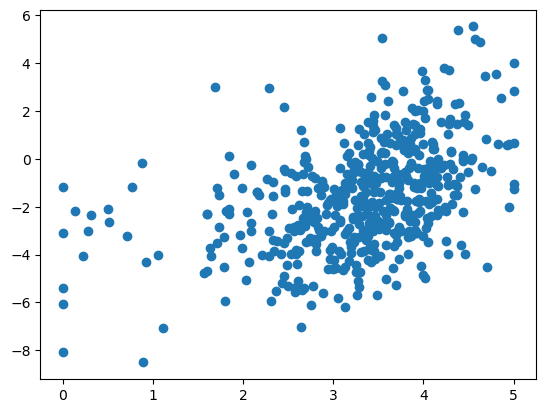

In [62]:
# plot all_preds vs all_true
import matplotlib.pyplot as plt
plt.scatter(all_true, all_preds)

In [102]:
# get pearson correlation all_preds vs all_true
from scipy.stats import pearsonr
pearsonr(all_true, all_preds)

(0.7763062567593562, 1.615810312193286e-113)

In [103]:
df = pd.DataFrame({"preds": all_preds, "true": all_true})

In [104]:
df.head()
df["preds"] = QuantileTransformer().fit_transform(df[["preds"]]) * 5

n_quantiles (1000) is greater than the total number of samples (558). n_quantiles is set to n_samples.


In [105]:
# compute top 20 accuracy
def compute_accuracy_at_k(df, k_list=[1,5,10,20,50]):
    out = {}
    for k in k_list:
        df["preds_rank"] = df["preds"].rank(ascending=False)
        df["true_rank"] = df["true"].rank(ascending=False)

        df["preds_rank"] = df["preds_rank"].astype(int)
        df["true_rank"] = df["true_rank"].astype(int)

        df["top_true"] = df["true_rank"].apply(lambda x: 1 if x <= k else 0)
        df["top_pred"] = df["preds_rank"].apply(lambda x: 1 if x <= k else 0)
        out[k] = (df["top_pred"] & df["top_true"]).sum() / k
    return out

In [106]:
out = compute_accuracy_at_k(df)

In [107]:
out

{1: 0.0, 5: 0.0, 10: 0.4, 20: 0.5, 50: 0.56}

Text(0.5, 1.0, 'RF Model')

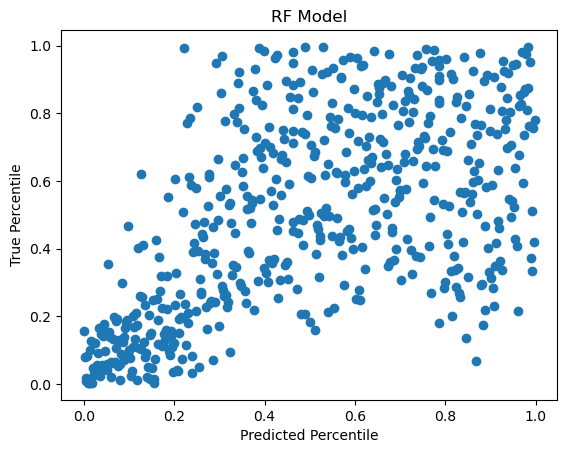

In [108]:
# compute pred_percentile
df["pred_percentile"] = df["preds"].rank(pct=True)
df["true_percentile"] = df["true"].rank(pct=True)

# plot
plt.scatter(1-df["pred_percentile"], 1-df["true_percentile"])
plt.xlabel("Predicted Percentile")
plt.ylabel("True Percentile")
plt.title("RF Model")

In [109]:
# compute residuals from x = y
df["residuals"] = df["pred_percentile"] - df["true_percentile"]

## SHAP explainer

In [110]:
# get some samples
X = []
y = []
for ex in ds_train:
    f, l = ex
    X.append(f[0,:])
    y.append(l[0])

In [111]:
X = torch.stack(X)

In [112]:
X = X.to(device)

In [113]:
X.shape

torch.Size([447, 100])

In [114]:
# expand middle dim
#X = X.unsqueeze(1)

In [2]:
X.shape

NameError: name 'X' is not defined

In [116]:
from shap import DeepExplainer

In [117]:
exp = DeepExplainer(model, X)

In [118]:
model(X).shape

torch.Size([447, 1])

In [119]:
shap_values = exp.shap_values(X)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [1]:
shap_values.shape

NameError: name 'shap_values' is not defined

In [120]:
from shap import summary_plot

In [121]:
# get X as numpy array
X_np = X.cpu().numpy()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


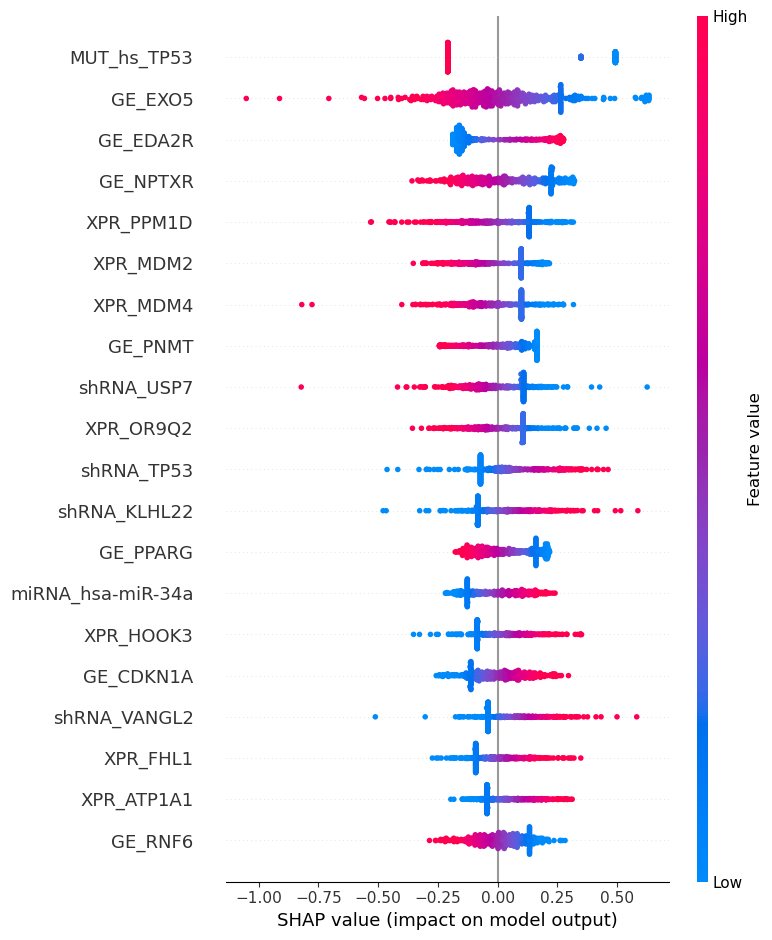

In [122]:
summary_plot(shap_values, X_np, feature_names=ds_train.joined_df.columns)

## STRINGDB API Call

In [123]:
# get the top 20 features from the shap values by name
top_20_features = np.argsort(np.abs(shap_values).mean(0))[-20:]
top_20_features = ds_train.joined_df.columns[top_20_features]

In [124]:
top_20_features

Index(['GE_RNF6', 'XPR_ATP1A1', 'XPR_FHL1', 'shRNA_VANGL2', 'GE_CDKN1A',
       'XPR_HOOK3', 'miRNA_hsa-miR-34a', 'GE_PPARG', 'shRNA_KLHL22',
       'shRNA_TP53', 'XPR_OR9Q2', 'shRNA_USP7', 'GE_PNMT', 'XPR_MDM4',
       'XPR_MDM2', 'XPR_PPM1D', 'GE_NPTXR', 'GE_EDA2R', 'GE_EXO5',
       'MUT_hs_TP53'],
      dtype='object')

In [125]:
# split on the last underscore, take the last element as gene name
top_20_features = [x.split("_")[-1] for x in top_20_features]
# set to a set to remove duplicates
top_20_features = list(set(top_20_features))

In [126]:
top_20_features

['MDM4',
 'CDKN1A',
 'VANGL2',
 'FHL1',
 'RNF6',
 'PNMT',
 'USP7',
 'EXO5',
 'MDM2',
 'ATP1A1',
 'KLHL22',
 'OR9Q2',
 'hsa-miR-34a',
 'EDA2R',
 'HOOK3',
 'NPTXR',
 'TP53',
 'PPM1D',
 'PPARG']

In [127]:
import stringdb

In [128]:
network_interactions = stringdb.get_network(top_20_features)

In [129]:
# process the network_interactions DataFrame to produce a list of edges
edges = []
for i, row in network_interactions.iterrows():
    edges.append((row["preferredName_A"], row["preferredName_B"]))
    edges.append((row["preferredName_B"], row["preferredName_A"]))
edges = list(set(edges))

In [130]:
network_interactions

,stringId_A,stringId_B,preferredName_A,preferredName_B,ncbiTaxonId,score,nscore,fscore,pscore,ascore,escore,dscore,tscore
0,9606.ENSP00000258149,9606.ENSP00000371000,MDM2,RNF6,9606,0.414,0,0,0,0.000,0.000,0.00,0.414
1,9606.ENSP00000258149,9606.ENSP00000371000,MDM2,RNF6,9606,0.414,0,0,0,0.000,0.000,0.00,0.414
2,9606.ENSP00000258149,9606.ENSP00000287820,MDM2,PPARG,9606,0.526,0,0,0,0.000,0.282,0.00,0.367
3,9606.ENSP00000258149,9606.ENSP00000287820,MDM2,PPARG,9606,0.526,0,0,0,0.000,0.282,0.00,0.367
4,9606.ENSP00000258149,9606.ENSP00000384849,MDM2,CDKN1A,9606,0.976,0,0,0,0.062,0.872,0.00,0.823
5,9606.ENSP00000258149,9606.ENSP00000384849,MDM2,CDKN1A,9606,0.976,0,0,0,0.062,0.872,0.00,0.823
6,9606.ENSP00000258149,9606.ENSP00000306682,MDM2,PPM1D,9606,0.978,0,0,0,0.062,0.270,0.90,0.720
7,9606.ENSP00000258149,9606.ENSP00000306682,MDM2,PPM1D,9606,0.978,0,0,0,0.062,0.270,0.90,0.720
8,9606.ENSP00000258149,9606.ENSP00000343535,MDM2,USP7,9606,0.999,0,0,0,0.062,0.920,0.90,0.989
9,9606.ENSP00000258149,9606.ENSP00000343535,MDM2,USP7,9606,0.999,0,0,0,0.062,0.920,0.90,0.989


## Try another compound

In [59]:
response_df = pd.read_csv("../20230523_G9a_inhibitors/data/responses/BIX-01294.csv")
feature_importance_df = pd.read_csv("../20230523_G9a_inhibitors/data/output/BIX-01294/all/BIX-01294_BRD-K13060017-001-01-3_auc_all_feature_importances.csv")

In [60]:
all_preds = []
all_true = []

NUM_FEATURES = 100
SLATE_LENGTH = 10
NUM_EPOCHS = 250
BATCH_SIZE = 512

# create summary writer
writer = SummaryWriter()

for i, (train_index, test_index) in enumerate(splitter.split(response_df)):
    print(f"Fold {i+1}")
    response_train = response_df.iloc[train_index, :].copy()
    response_test = response_df.iloc[test_index, :].copy()
    ds_train = PrismDataset(response_train, feature_df, feature_importance_df, NUM_FEATURES, SLATE_LENGTH)
    dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

    model = FeedForwardNet(NUM_FEATURES)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(NUM_EPOCHS):
        for batch in dl_train:
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)
            pred_scores = model(features).squeeze()
            loss = lambdaLoss(pred_scores, labels, weighing_scheme="lambdaRank_scheme", k=SLATE_LENGTH)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, NUM_EPOCHS, loss.item()))
        writer.add_scalar("Loss/train", loss.item(), epoch)


    model.eval()
    train_preds = []
    train_true = []
    for ex in ds_train:
        f, l = ex
        pred = model(f.to(device))[0]
        train_preds.append(float(pred))
        train_true.append(float(l[0]))
    # compute pearsonr 
    train_pearsonr = pearsonr(train_preds, train_true)

    # test pred scores
    preds = []
    true = []
    ds_test = PrismDataset(response_test, feature_df, feature_importance_df, NUM_FEATURES, SLATE_LENGTH, quantile_transfomer=ds_train.quantile_transfomer)
    for ex in ds_test:
        f, l = ex
        pred = model(f.to(device))[0]
        preds.append(float(pred))
        true.append(float(l[0]))
    # compute pearsonr
    test_pearsonr = pearsonr(preds, true)
    writer.add_scalar("Pearsonr/train", train_pearsonr[0], i)
    writer.add_scalar("Pearsonr/test", test_pearsonr[0], i)

    # append to all preds
    all_preds.extend(preds)
    all_true.extend(true)

Fold 1
Epoch [1/250], Loss: 363.8433
Epoch [2/250], Loss: 355.5706
Epoch [3/250], Loss: 345.2207
Epoch [4/250], Loss: 341.3304
Epoch [5/250], Loss: 348.0970
Epoch [6/250], Loss: 338.8568
Epoch [7/250], Loss: 332.8329
Epoch [8/250], Loss: 321.0694
Epoch [9/250], Loss: 320.3774
Epoch [10/250], Loss: 315.6178
Epoch [11/250], Loss: 303.3858
Epoch [12/250], Loss: 307.3041
Epoch [13/250], Loss: 292.3451
Epoch [14/250], Loss: 289.1200
Epoch [15/250], Loss: 267.1402
Epoch [16/250], Loss: 263.5861
Epoch [17/250], Loss: 269.6903
Epoch [18/250], Loss: 257.5894
Epoch [19/250], Loss: 250.0202
Epoch [20/250], Loss: 241.5120
Epoch [21/250], Loss: 236.9745
Epoch [22/250], Loss: 235.8647
Epoch [23/250], Loss: 231.9266
Epoch [24/250], Loss: 224.0441
Epoch [25/250], Loss: 223.7402
Epoch [26/250], Loss: 217.0277
Epoch [27/250], Loss: 213.8778
Epoch [28/250], Loss: 224.0755
Epoch [29/250], Loss: 222.8141
Epoch [30/250], Loss: 221.2290
Epoch [31/250], Loss: 211.9710
Epoch [32/250], Loss: 201.8400
Epoch [33/

KeyboardInterrupt: 

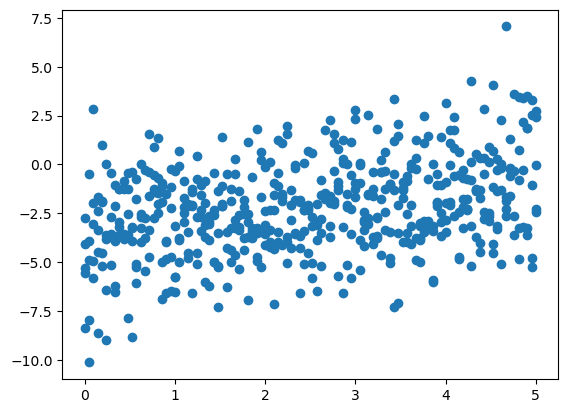

In [ ]:
# plot all_preds vs all_true
import matplotlib.pyplot as plt
plt.scatter(all_true, all_preds)

In [ ]:
# get pearson correlation all_preds vs all_true
from scipy.stats import pearsonr
pearsonr(all_true, all_preds)

(0.34482107709236903, 3.9350964819156573e-16)

In [ ]:
df = pd.DataFrame({"preds": all_preds, "true": all_true})

In [ ]:
df.head()
df["preds"] = QuantileTransformer().fit_transform(df[["preds"]]) * 5

n_quantiles (1000) is greater than the total number of samples (526). n_quantiles is set to n_samples.


In [ ]:
out = compute_accuracy_at_k(df)

In [ ]:
out

{1: 0.0, 5: 0.0, 10: 0.1, 20: 0.3, 50: 0.28}

Text(0.5, 1.0, 'RF Model')

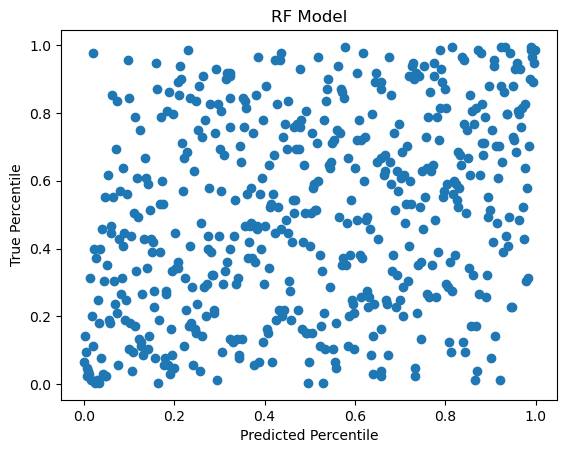

In [ ]:
# compute pred_percentile
df["pred_percentile"] = df["preds"].rank(pct=True)
df["true_percentile"] = df["true"].rank(pct=True)

# plot
plt.scatter(1-df["pred_percentile"], 1-df["true_percentile"])
plt.xlabel("Predicted Percentile")
plt.ylabel("True Percentile")
plt.title("RF Model")

In [ ]:
# get some samples
X = []
y = []
for ex in ds_train:
    f, l = ex
    if l[0] > 4.5 or l[0] < 0.5:
        X.append(f[0,:])
        y.append(l[0])

In [ ]:
X = torch.stack(X)

In [ ]:
X = X.to(device)

In [ ]:
exp = DeepExplainer(model, X)

In [ ]:
shap_values = exp.shap_values(X)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
# get X as numpy array
X_np = X.cpu().numpy()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


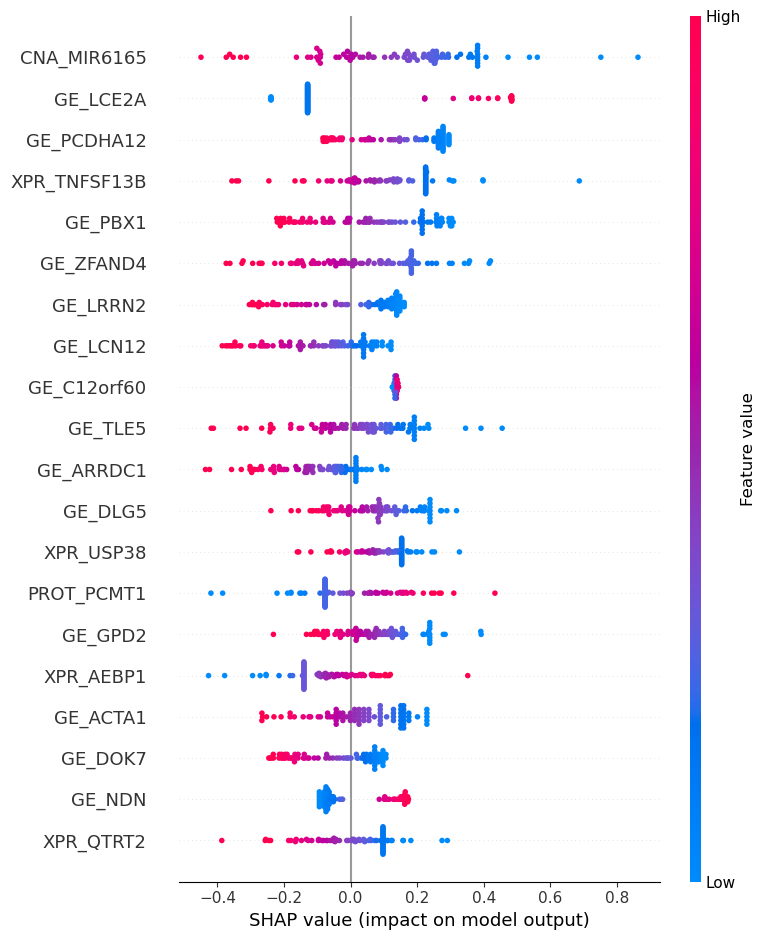

In [ ]:
summary_plot(shap_values, X_np, feature_names=ds_train.joined_df.columns)